When estimating a latent proportion, the observed data may be influenced by biases or confounding effects. These confounding factors can distort the observed proportion, making it different from the true underlying proportion (the latent variable) that we aim to estimate.

In Bayesian modeling, we account for these biases or confounders by:

1. Modeling the observed proportion as a noisy or biased version of the latent (true) proportion.
2. Estimating the latent proportion by introducing parameters that adjust for the bias, based on assumptions or prior knowledge about how the bias or confounder affects the data.

This approach helps isolate the true underlying proportion by incorporating uncertainty and correcting for systematic distortions that might affect the observations.

The optimization method is Markov-Chain Montecarlo MCMC-NUTS. Estimation works in this way:
1. Initialize values for all distributions by each chain
2. Each chain will be a sequence of samples (NUTS)
3. During tuning phase the sampler adjusts its internal parameters
4. Generate samples from the posterior distribution (No-U-Turn Sampler (NUTS))
5. Samples are needed to generate the posterior distribution
6. Over iterations convergence is evaluated

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import beta

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# globals
alpha_prior = 2 # weight of success, the larger alpha the larger the proportion
beta_prior = 5 # weight of failure, the larger beta the lower the proportion
observed_proportion = 0.3
n_obs = 100

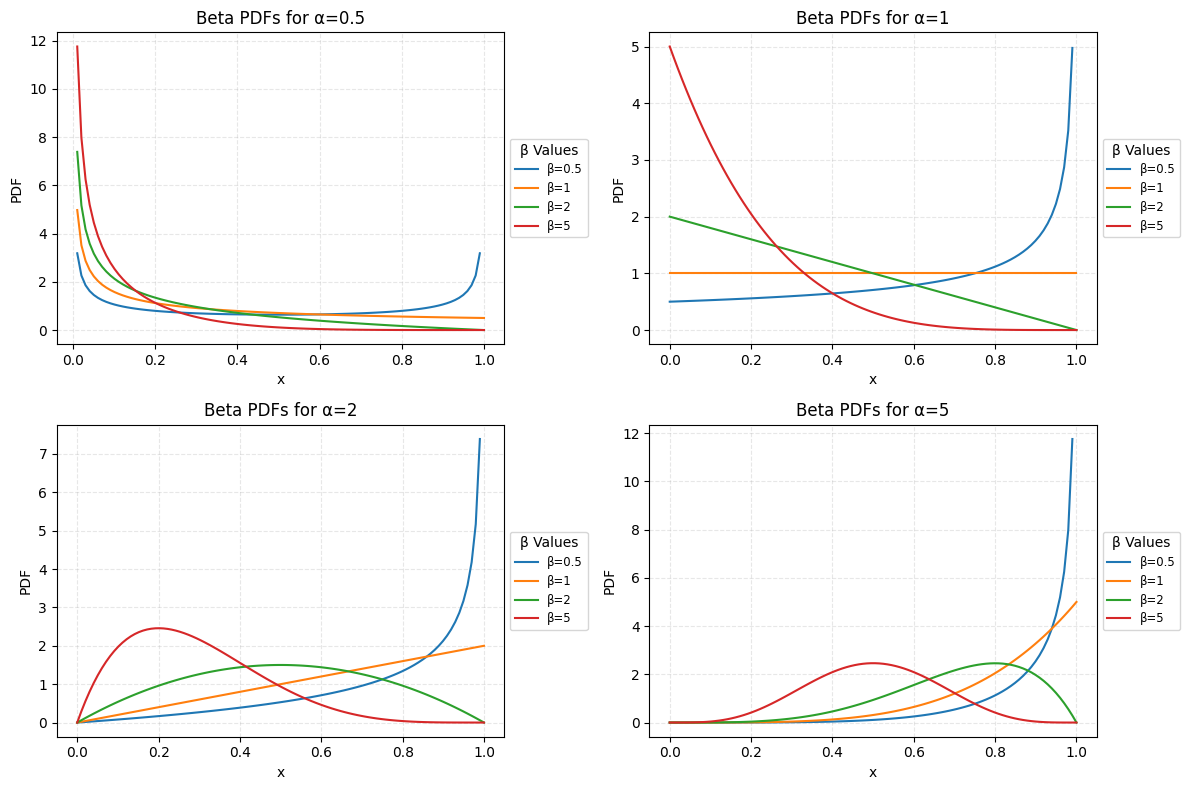

In [3]:
# beta distribution illustration
alpha_values = [0.5, 1, 2, 5] # weight of success, the larger alpha the larger the proportion
beta_values = [0.5, 1, 2, 5] # weight of failure, the larger beta the lower the proportion
x = np.linspace(0, 1, n_obs)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, alpha in enumerate(alpha_values):
    for beta_val in beta_values:
        y = beta.pdf(x, alpha, beta_val)
        # y = beta.cdf(x, alpha, beta_val)
        axs[i].plot(x, y, label=f'β={beta_val}')
    axs[i].set_title(f'Beta PDFs for α={alpha}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('PDF')
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title='β Values')
    axs[i].grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

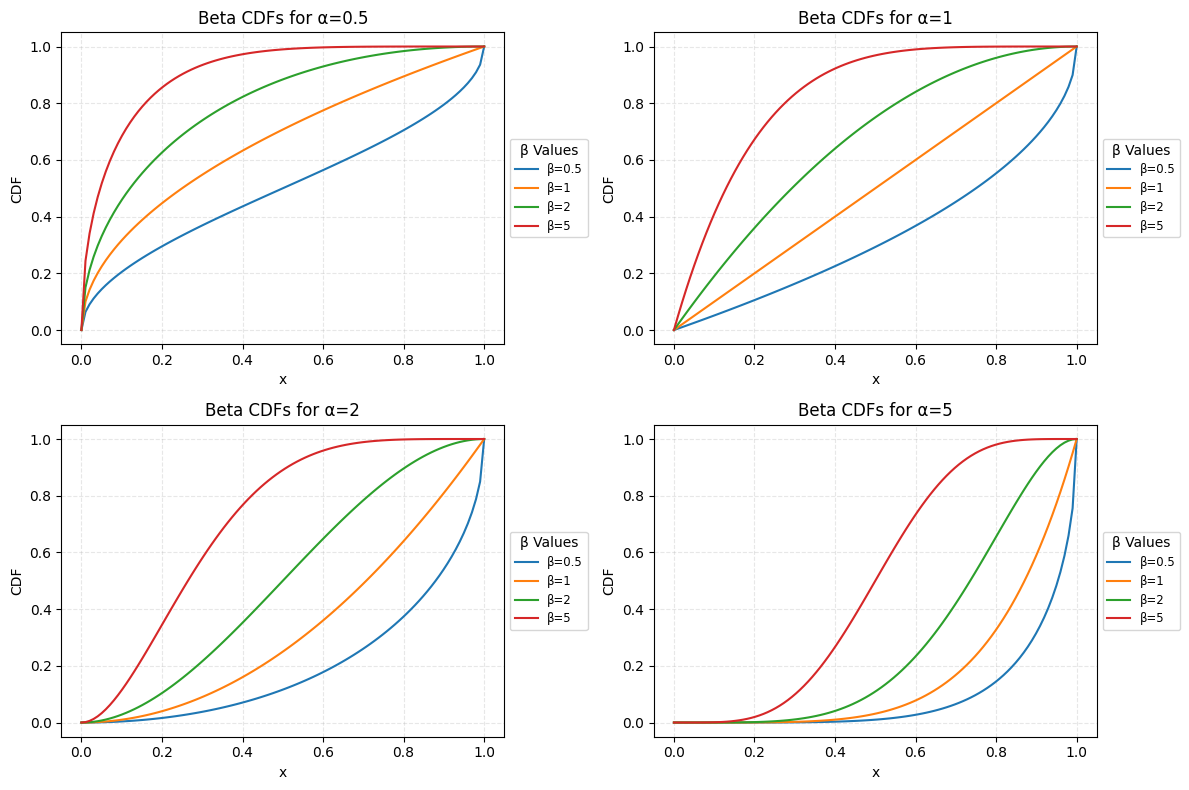

In [4]:
# beta distribution illustration
alpha_values = [0.5, 1, 2, 5] # weight of success, the larger alpha the larger the proportion
beta_values = [0.5, 1, 2, 5] # weight of failure, the larger beta the lower the proportion
x = np.linspace(0, 1, n_obs)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, alpha in enumerate(alpha_values):
    for beta_val in beta_values:
        # y = beta.pdf(x, alpha, beta_val)
        y = beta.cdf(x, alpha, beta_val)
        axs[i].plot(x, y, label=f'β={beta_val}')
    axs[i].set_title(f'Beta CDFs for α={alpha}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('CDF')
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title='β Values')
    axs[i].grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Model with Random Noise Bias

In [5]:
# Model Estimation and Inference
with pm.Model() as model:
    # Prior for the true proportion (latent variable)
    p_true = pm.Beta("p_true", alpha=alpha_prior, beta=beta_prior)
    
    # Bias due to confounders, which adds to the true proportion
    bias = pm.Normal("bias", mu=0, sigma=0.05)
    
    # Modeled observed proportion as a sum of the true proportion and bias
    p_obs = pm.Deterministic("p_obs", p_true + bias)
    
    # Likelihood for the observed proportion
    likelihood = pm.Normal("likelihood", mu=p_obs, sigma=0.05, observed=observed_proportion)
    
    # Sampling from the posterior
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_true, bias]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


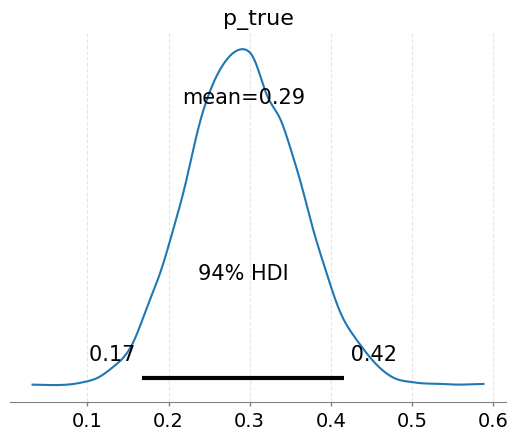

In [6]:
# Plot posterior for p_true with Highest Density Interval (HDI)
pm.plot_posterior(trace, var_names=["p_true"])
plt.grid(alpha=0.3,linestyle="--")
plt.show()

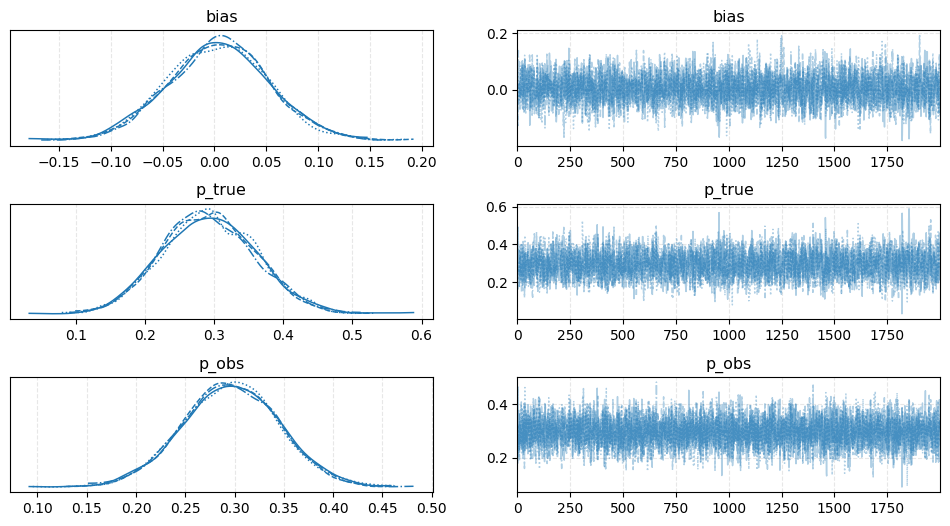

In [7]:
axes = pm.plot_trace(trace)
for ax in axes.flatten():  # Flatten the array to iterate through each axis
    ax.grid(alpha=0.3, linestyle="--")
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# smooth and unimodal disitributions of energy tranistion and marginal energy indicate convergence
pm.plot_energy(trace);

# Model with Systematic Bias

In [8]:
# Model Estimation and Inference
with pm.Model() as model:
    # Prior for the true proportion (latent variable)
    p_true = pm.Beta("p_true", alpha=alpha_prior, beta=beta_prior)
    
    # Bias due to confounders, which adds to the true proportion
    bias = pm.Normal("bias", mu=0.2, sigma=0.05)
    
    # Modeled observed proportion as a sum of the true proportion and bias
    p_obs = pm.Deterministic("p_obs", p_true + bias)
    
    # Likelihood for the observed proportion. The likelihood is not a parameter to estimate.
    likelihood = pm.Normal("likelihood", mu=p_obs, sigma=0.05, observed=observed_proportion)
    
    # Sampling from the posterior. Only parameters to estimate are p_true, bias
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_true, bias]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


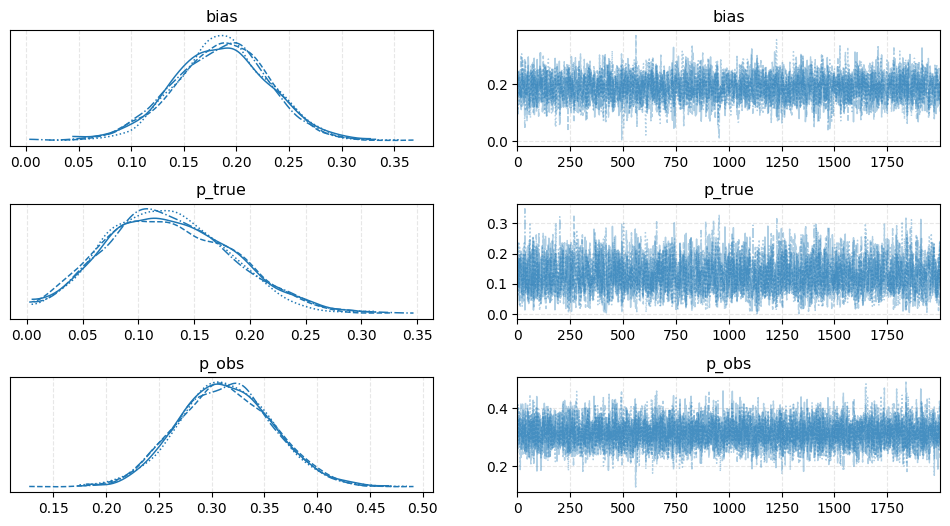

In [9]:
axes = pm.plot_trace(trace)
for ax in axes.flatten():  # Flatten the array to iterate through each axis
    ax.grid(alpha=0.3, linestyle="--")
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# smooth and unimodal disitributions of energy tranistion and marginal energy indicate convergence
pm.plot_energy(trace);

The above model represents a Latent Variable Estimation with an introduction of a bias component. The variable ``p_true`` is considered a latent variable because it is not directly observed but inferred through the model.

# Model with Systematic Bias: synthetic data

In [31]:
np.random.seed(42)
# Generate synthetic data for confounders
n_samples = 500
confounder1 = np.random.normal(loc=0.1, scale=1, size=n_samples)
confounder2 = np.random.normal(loc=0.05, scale=1, size=n_samples)
# True proportion without bias
true_proportion = 0.3
# Bias generated as a linear combination of confounders
bias = 0.1 * confounder1 + 0.05 * confounder2
# Observed proportion (adding bias to the true proportion and clipping for valid values)
observed_proportion = np.clip(true_proportion + bias, 0, 1)
# Create a DataFrame to hold the data
data = pd.DataFrame({'confounder1': confounder1, 'confounder2': confounder2, 'observed_proportion': observed_proportion})

In [32]:
with pm.Model() as model:
    # Prior for the true proportion (latent variable)
    p_true = pm.Beta("p_true", alpha=1, beta=1)
    
    # Bias as a function of confounders, modeled as a normal distribution
    bias_coeff1 = pm.Normal("bias_coeff1", mu=0, sigma=0.1)
    bias_coeff2 = pm.Normal("bias_coeff2", mu=0, sigma=0.1)
    bias = pm.Deterministic("bias", bias_coeff1 * data['confounder1'] + bias_coeff2 * data['confounder2'])
    
    # Modeled observed proportion as a sum of the true proportion and bias
    p_obs = pm.Deterministic("p_obs", pm.math.clip(p_true + bias, 0, 1))
    
    # Likelihood for the observed proportion, modeled as Normal
    likelihood = pm.Normal("likelihood", mu=p_obs, sigma=0.05, observed=data['observed_proportion'])
    
    # Sampling from the posterior
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_true, bias_coeff1, bias_coeff2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 670 seconds.


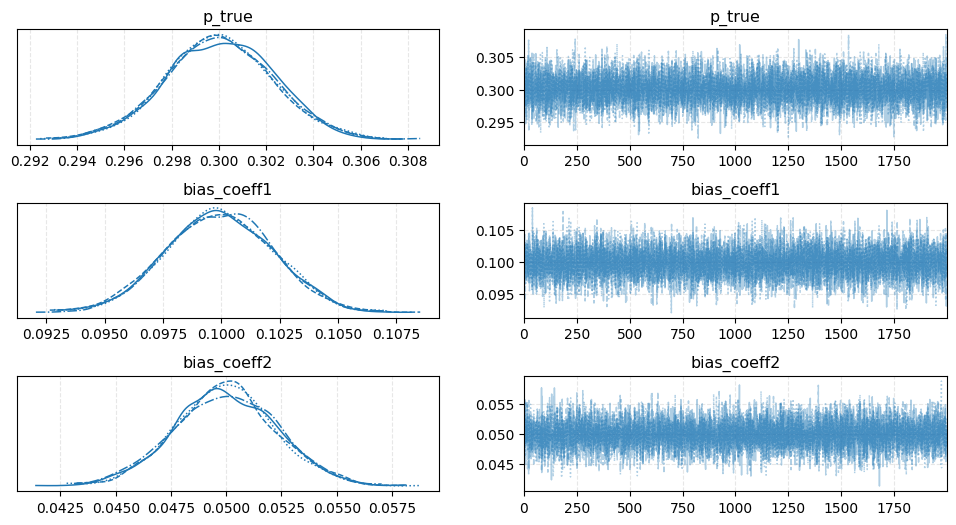

In [33]:
axes = pm.plot_trace(trace, var_names=["p_true", "bias_coeff1", "bias_coeff2"])
for ax in axes.flatten():  # Flatten the array to iterate through each axis
    ax.grid(alpha=0.3, linestyle="--")
plt.subplots_adjust(hspace=0.5)
plt.show()

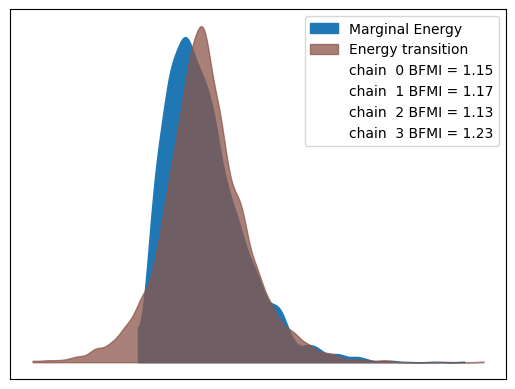

In [34]:
# smooth and unimodal disitributions of energy tranistion and marginal energy indicate convergence
pm.plot_energy(trace);